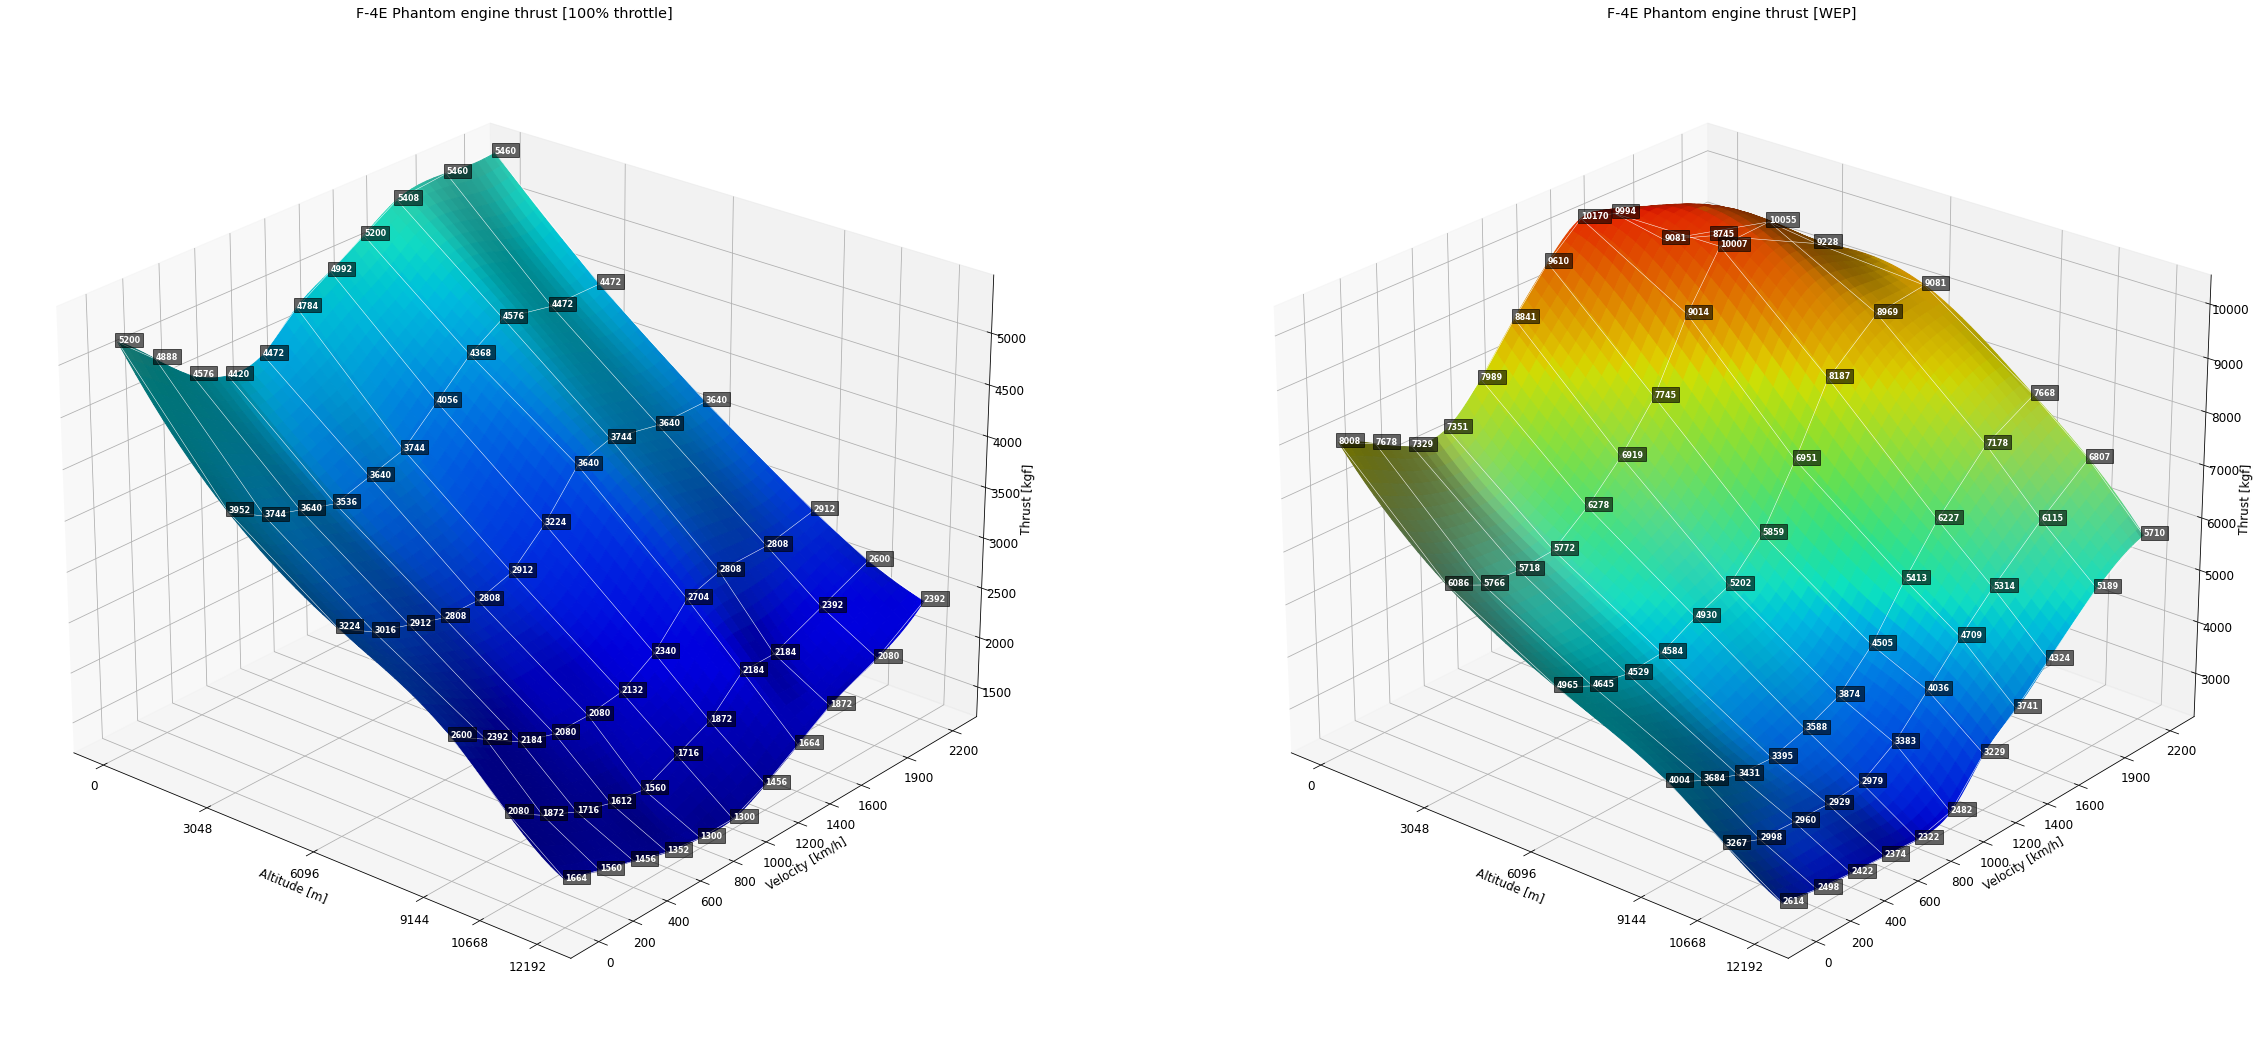

In [42]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import scipy.interpolate as sp
import re

baseThrust = 5200 # ThrustMax0 from blkx

boostAfterburn = 1.1 # AfterburnerBoost from blkx

boostWep = 1.4 # ThrustMult - mode with 110% throttle
boostNoWep = 1.0 # ThrustMult - mode with 100% throttle


# altitudes in meters from blkx, they do change
alts = [
	0,
	3048,
	6096,
	9144,
	10668,
        12192,
]

# velocities in kph (TAS) from blkx, not too much data to rewrite by hand, not sure if they change at all
vels = [
	0,
	200,
	400,
	600,
	800,
	1000,
	1200,
	1400,
        1600,
        1900,
        2200,
]

# too much data to rewrite, so pasted coefs from blkx without initial thrust
data = """
        "ThrustMaxCoeff_0_0": 1.0,
        "ThrAftMaxCoeff_0_0": 1.0,
        "TorqueMaxCoeff_0_0": 1.0,
        "ThrustMaxCoeff_0_1": 0.94,
        "ThrAftMaxCoeff_0_1": 1.02,
        "TorqueMaxCoeff_0_1": 0.94,
        "ThrustMaxCoeff_0_2": 0.88,
        "ThrAftMaxCoeff_0_2": 1.04,
        "TorqueMaxCoeff_0_2": 0.88,
        "ThrustMaxCoeff_0_3": 0.85,
        "ThrAftMaxCoeff_0_3": 1.08,
        "TorqueMaxCoeff_0_3": 0.85,
        "ThrustMaxCoeff_0_4": 0.86,
        "ThrAftMaxCoeff_0_4": 1.16,
        "TorqueMaxCoeff_0_4": 0.86,
        "ThrustMaxCoeff_0_5": 0.92,
        "ThrAftMaxCoeff_0_5": 1.2,
        "TorqueMaxCoeff_0_5": 0.92,
        "ThrustMaxCoeff_0_6": 0.96,
        "ThrAftMaxCoeff_0_6": 1.25,
        "TorqueMaxCoeff_0_6": 0.96,
        "ThrustMaxCoeff_0_7": 1.0,
        "ThrAftMaxCoeff_0_7": 1.27,
        "TorqueMaxCoeff_0_7": 1.0,
        "ThrustMaxCoeff_0_8": 1.04,
        "ThrAftMaxCoeff_0_8": 1.2,
        "TorqueMaxCoeff_0_8": 1.04,
        "ThrustMaxCoeff_0_9": 1.05,
        "ThrAftMaxCoeff_0_9": 1.08,
        "TorqueMaxCoeff_0_9": 1.05,
        "ThrustMaxCoeff_0_10": 1.05,
        "ThrAftMaxCoeff_0_10": 1.04,
        "TorqueMaxCoeff_0_10": 1.05,
        "ThrustMaxCoeff_1_0": 0.76,
        "ThrAftMaxCoeff_1_0": 1.0,
        "TorqueMaxCoeff_1_0": 0.76,
        "ThrustMaxCoeff_1_1": 0.72,
        "ThrAftMaxCoeff_1_1": 1.0,
        "TorqueMaxCoeff_1_1": 0.72,
        "ThrustMaxCoeff_1_2": 0.7,
        "ThrAftMaxCoeff_1_2": 1.02,
        "TorqueMaxCoeff_1_2": 0.7,
        "ThrustMaxCoeff_1_3": 0.68,
        "ThrAftMaxCoeff_1_3": 1.06,
        "TorqueMaxCoeff_1_3": 0.68,
        "ThrustMaxCoeff_1_4": 0.7,
        "ThrAftMaxCoeff_1_4": 1.12,
        "TorqueMaxCoeff_1_4": 0.7,
        "ThrustMaxCoeff_1_5": 0.72,
        "ThrAftMaxCoeff_1_5": 1.2,
        "TorqueMaxCoeff_1_5": 0.72,
        "ThrustMaxCoeff_1_6": 0.78,
        "ThrAftMaxCoeff_1_6": 1.24,
        "TorqueMaxCoeff_1_6": 0.78,
        "ThrustMaxCoeff_1_7": 0.84,
        "ThrAftMaxCoeff_1_7": 1.34,
        "TorqueMaxCoeff_1_7": 0.84,
        "ThrustMaxCoeff_1_8": 0.88,
        "ThrAftMaxCoeff_1_8": 1.42,
        "TorqueMaxCoeff_1_8": 0.88,
        "ThrustMaxCoeff_1_9": 0.86,
        "ThrAftMaxCoeff_1_9": 1.46,
        "TorqueMaxCoeff_1_9": 0.86,
        "ThrustMaxCoeff_1_10": 0.86,
        "ThrAftMaxCoeff_1_10": 1.34,
        "TorqueMaxCoeff_1_10": 0.86,
        "ThrustMaxCoeff_2_0": 0.62,
        "ThrAftMaxCoeff_2_0": 1.0,
        "TorqueMaxCoeff_2_0": 0.62,
        "ThrustMaxCoeff_2_1": 0.58,
        "ThrAftMaxCoeff_2_1": 1.0,
        "TorqueMaxCoeff_2_1": 0.58,
        "ThrustMaxCoeff_2_2": 0.56,
        "ThrAftMaxCoeff_2_2": 1.01,
        "TorqueMaxCoeff_2_2": 0.56,
        "ThrustMaxCoeff_2_3": 0.54,
        "ThrAftMaxCoeff_2_3": 1.06,
        "TorqueMaxCoeff_2_3": 0.54,
        "ThrustMaxCoeff_2_4": 0.54,
        "ThrAftMaxCoeff_2_4": 1.14,
        "TorqueMaxCoeff_2_4": 0.54,
        "ThrustMaxCoeff_2_5": 0.56,
        "ThrAftMaxCoeff_2_5": 1.16,
        "TorqueMaxCoeff_2_5": 0.56,
        "ThrustMaxCoeff_2_6": 0.62,
        "ThrAftMaxCoeff_2_6": 1.18,
        "TorqueMaxCoeff_2_6": 0.62,
        "ThrustMaxCoeff_2_7": 0.7,
        "ThrAftMaxCoeff_2_7": 1.24,
        "TorqueMaxCoeff_2_7": 0.7,
        "ThrustMaxCoeff_2_8": 0.72,
        "ThrAftMaxCoeff_2_8": 1.42,
        "TorqueMaxCoeff_2_8": 0.72,
        "ThrustMaxCoeff_2_9": 0.7,
        "ThrAftMaxCoeff_2_9": 1.6,
        "TorqueMaxCoeff_2_9": 0.7,
        "ThrustMaxCoeff_2_10": 0.7,
        "ThrAftMaxCoeff_2_10": 1.62,
        "TorqueMaxCoeff_2_10": 0.7,
        "ThrustMaxCoeff_3_0": 0.5,
        "ThrAftMaxCoeff_3_0": 1.0,
        "TorqueMaxCoeff_3_0": 0.5,
        "ThrustMaxCoeff_3_1": 0.46,
        "ThrAftMaxCoeff_3_1": 1.0,
        "TorqueMaxCoeff_3_1": 0.46,
        "ThrustMaxCoeff_3_2": 0.42,
        "ThrAftMaxCoeff_3_2": 1.02,
        "TorqueMaxCoeff_3_2": 0.42,
        "ThrustMaxCoeff_3_3": 0.4,
        "ThrAftMaxCoeff_3_3": 1.06,
        "TorqueMaxCoeff_3_3": 0.4,
        "ThrustMaxCoeff_3_4": 0.4,
        "ThrAftMaxCoeff_3_4": 1.12,
        "TorqueMaxCoeff_3_4": 0.4,
        "ThrustMaxCoeff_3_5": 0.41,
        "ThrAftMaxCoeff_3_5": 1.18,
        "TorqueMaxCoeff_3_5": 0.41,
        "ThrustMaxCoeff_3_6": 0.45,
        "ThrAftMaxCoeff_3_6": 1.25,
        "TorqueMaxCoeff_3_6": 0.45,
        "ThrustMaxCoeff_3_7": 0.52,
        "ThrAftMaxCoeff_3_7": 1.3,
        "TorqueMaxCoeff_3_7": 0.52,
        "ThrustMaxCoeff_3_8": 0.54,
        "ThrAftMaxCoeff_3_8": 1.44,
        "TorqueMaxCoeff_3_8": 0.54,
        "ThrustMaxCoeff_3_9": 0.54,
        "ThrAftMaxCoeff_3_9": 1.66,
        "TorqueMaxCoeff_3_9": 0.54,
        "ThrustMaxCoeff_3_10": 0.56,
        "ThrAftMaxCoeff_3_10": 1.71,
        "TorqueMaxCoeff_3_10": 0.56,
        "ThrustMaxCoeff_4_0": 0.4,
        "ThrAftMaxCoeff_4_0": 1.02,
        "TorqueMaxCoeff_4_0": 0.4,
        "ThrustMaxCoeff_4_1": 0.36,
        "ThrAftMaxCoeff_4_1": 1.04,
        "TorqueMaxCoeff_4_1": 0.36,
        "ThrustMaxCoeff_4_2": 0.33,
        "ThrAftMaxCoeff_4_2": 1.12,
        "TorqueMaxCoeff_4_2": 0.33,
        "ThrustMaxCoeff_4_3": 0.31,
        "ThrAftMaxCoeff_4_3": 1.18,
        "TorqueMaxCoeff_4_3": 0.31,
        "ThrustMaxCoeff_4_4": 0.3,
        "ThrAftMaxCoeff_4_4": 1.24,
        "TorqueMaxCoeff_4_4": 0.3,
        "ThrustMaxCoeff_4_5": 0.33,
        "ThrAftMaxCoeff_4_5": 1.28,
        "TorqueMaxCoeff_4_5": 0.33,
        "ThrustMaxCoeff_4_6": 0.36,
        "ThrAftMaxCoeff_4_6": 1.4,
        "TorqueMaxCoeff_4_6": 0.36,
        "ThrustMaxCoeff_4_7": 0.42,
        "ThrAftMaxCoeff_4_7": 1.4,
        "TorqueMaxCoeff_4_7": 0.42,
        "ThrustMaxCoeff_4_8": 0.42,
        "ThrAftMaxCoeff_4_8": 1.58,
        "TorqueMaxCoeff_4_8": 0.42,
        "ThrustMaxCoeff_4_9": 0.46,
        "ThrAftMaxCoeff_4_9": 1.66,
        "TorqueMaxCoeff_4_9": 0.46,
        "ThrustMaxCoeff_4_10": 0.5,
        "ThrAftMaxCoeff_4_10": 1.7,
        "TorqueMaxCoeff_4_10": 0.5,
        "ThrustMaxCoeff_5_0": 0.32,
        "ThrAftMaxCoeff_5_0": 1.02,
        "TorqueMaxCoeff_5_0": 0.32,
        "ThrustMaxCoeff_5_1": 0.3,
        "ThrAftMaxCoeff_5_1": 1.04,
        "TorqueMaxCoeff_5_1": 0.3,
        "ThrustMaxCoeff_5_2": 0.28,
        "ThrAftMaxCoeff_5_2": 1.08,
        "TorqueMaxCoeff_5_2": 0.28,
        "ThrustMaxCoeff_5_3": 0.26,
        "ThrAftMaxCoeff_5_3": 1.14,
        "TorqueMaxCoeff_5_3": 0.26,
        "ThrustMaxCoeff_5_4": 0.25,
        "ThrAftMaxCoeff_5_4": 1.16,
        "TorqueMaxCoeff_5_4": 0.25,
        "ThrustMaxCoeff_5_5": 0.25,
        "ThrAftMaxCoeff_5_5": 1.24,
        "TorqueMaxCoeff_5_5": 0.25,
        "ThrustMaxCoeff_5_6": 0.28,
        "ThrAftMaxCoeff_5_6": 1.44,
        "TorqueMaxCoeff_5_6": 0.28,
        "ThrustMaxCoeff_5_7": 0.32,
        "ThrAftMaxCoeff_5_7": 1.46,
        "TorqueMaxCoeff_5_7": 0.32,
        "ThrustMaxCoeff_5_8": 0.36,
        "ThrAftMaxCoeff_5_8": 1.5,
        "TorqueMaxCoeff_5_8": 0.36,
        "ThrustMaxCoeff_5_9": 0.4,
        "ThrAftMaxCoeff_5_9": 1.62,
        "TorqueMaxCoeff_5_9": 0.4,
        "ThrustMaxCoeff_5_10": 0.46,
        "ThrAftMaxCoeff_5_10": 1.55,
        "TorqueMaxCoeff_5_10": 0.46,
        "ThrustMaxCoeff_6_0": 0.2,
        "ThrAftMaxCoeff_6_0": 1.01,
        "TorqueMaxCoeff_6_0": 0.2,
        "ThrustMaxCoeff_6_1": 0.18,
        "ThrAftMaxCoeff_6_1": 1.02,
        "TorqueMaxCoeff_6_1": 0.18,
        "ThrustMaxCoeff_6_2": 0.175,
        "ThrAftMaxCoeff_6_2": 1.04,
        "TorqueMaxCoeff_6_2": 0.175,
        "ThrustMaxCoeff_6_3": 0.17,
        "ThrAftMaxCoeff_6_3": 1.06,
        "TorqueMaxCoeff_6_3": 0.17,
        "ThrustMaxCoeff_6_4": 0.18,
        "ThrAftMaxCoeff_6_4": 1.12,
        "TorqueMaxCoeff_6_4": 0.18,
        "ThrustMaxCoeff_6_5": 0.21,
        "ThrAftMaxCoeff_6_5": 1.18,
        "TorqueMaxCoeff_6_5": 0.21,
        "ThrustMaxCoeff_6_6": 0.24,
        "ThrAftMaxCoeff_6_6": 1.22,
        "TorqueMaxCoeff_6_6": 0.24,
        "ThrustMaxCoeff_6_7": 0.26,
        "ThrAftMaxCoeff_6_7": 1.3,
        "TorqueMaxCoeff_6_7": 0.26,
        "ThrustMaxCoeff_6_8": 0.28,
        "ThrAftMaxCoeff_6_8": 1.32,
        "TorqueMaxCoeff_6_8": 0.28,
        "ThrustMaxCoeff_6_9": 0.3,
        "ThrAftMaxCoeff_6_9": 1.32,
        "TorqueMaxCoeff_6_9": 0.3,
        "ThrustMaxCoeff_6_10": 0.3,
        "ThrAftMaxCoeff_6_10": 1.32,
        "TorqueMaxCoeff_6_10": 0.3,
        "ThrustMaxCoeff_7_0": 0.06,
        "ThrAftMaxCoeff_7_0": 1.01,
        "TorqueMaxCoeff_7_0": 0.06,
        "ThrustMaxCoeff_7_1": 0.05,
        "ThrAftMaxCoeff_7_1": 1.02,
        "TorqueMaxCoeff_7_1": 0.05,
        "ThrustMaxCoeff_7_2": 0.04,
        "ThrAftMaxCoeff_7_2": 1.04,
        "TorqueMaxCoeff_7_2": 0.04,
        "ThrustMaxCoeff_7_3": 0.05,
        "ThrAftMaxCoeff_7_3": 1.06,
        "TorqueMaxCoeff_7_3": 0.05,
        "ThrustMaxCoeff_7_4": 0.06,
        "ThrAftMaxCoeff_7_4": 1.08,
        "TorqueMaxCoeff_7_4": 0.06,
        "ThrustMaxCoeff_7_5": 0.07,
        "ThrAftMaxCoeff_7_5": 1.1,
        "TorqueMaxCoeff_7_5": 0.07,
        "ThrustMaxCoeff_7_6": 0.08,
        "ThrAftMaxCoeff_7_6": 1.12,
        "TorqueMaxCoeff_7_6": 0.08,
        "ThrustMaxCoeff_7_7": 0.09,
        "ThrAftMaxCoeff_7_7": 1.14,
        "TorqueMaxCoeff_7_7": 0.09,
        "ThrustMaxCoeff_7_8": 0.1,
        "ThrAftMaxCoeff_7_8": 1.16,
        "TorqueMaxCoeff_7_8": 0.1,
        "ThrustMaxCoeff_7_9": 0.11,
        "ThrAftMaxCoeff_7_9": 1.18,
        "TorqueMaxCoeff_7_9": 0.11,
        "ThrustMaxCoeff_7_10": 0.12,
        "ThrAftMaxCoeff_7_10": 1.18,
        "TorqueMaxCoeff_7_10": 0.12"""

data = data.strip("\n ").replace('"', "").split(',\n') # clear some garbaggio from string
thrustCurve = np.zeros((len(alts), len(vels), 2))

alts2 = np.linspace(min(alts), max(alts), 100)
vels2 = np.linspace(min(vels), max(vels), 100)

xV, yV =  np.meshgrid(alts, vels) # map velocities to altitudes and altitudes to velocities so we can graph it

# parsing thrust multipliers from the data above
for x in data:
        x = x.strip("\t\n ") # clear more garbaggio from string
        groups = re.match('(.*)_(\d+)_(\d+): (.*)', x) # regexp magic
        groups = groups.groups()
        dataType = groups[0]
        if dataType == "TorqueMaxCoeff": # we're not interested in torque, skip it
                continue
        alt = int(groups[1])
        vel = int(groups[2])
        mul = float(groups[3])
        try: # not gonna implement proper exception handling here; temporary solution before .blkx parsing
                if dataType == "ThrustMaxCoeff":
                        thrustCurve[alt][vel][0] = mul # set mul for 100% throttle
                elif dataType == "ThrAftMaxCoeff":
                        thrustCurve[alt][vel][1] = mul # this is not final afterburner multiplier, it'll get multiplied by 100% mul
        except:
                continue

# some graph config
angs = (25, -50) # viewport angle (pitch, yaw)

cmap = "jet" # color spectrum for values
vMin = 1000 # color range minimum value
vMax = 12000 # color range maximum value
ls = LightSource(130, 40)

x2V, y2V = np.meshgrid(alts2, vels2)
interp100 = sp.interp2d(alts, vels, thrustCurve[:,:,0].flatten(), kind="cubic")
interpWEP = sp.interp2d(alts, vels, thrustCurve[:,:,1].flatten(), kind="cubic")
zVal100 = interp100(alts2, vels2)
zValWEP = interpWEP(alts2, vels2)

# prepare the graph
fig = plt.figure(figsize=plt.figaspect(0.5)*5)
# make the font a little bigger
plt.rcParams.update({'font.size': 12})
ax = fig.add_subplot(1, 2, 1, projection="3d")

# actual thrust calculation at 100% throttle
thrust100 = baseThrust * boostNoWep * (thrustCurve[:,:,0])
thrust100_interp = baseThrust * boostNoWep * (zVal100)
rgb = ls.shade(thrust100_interp, cmap=plt.cm.jet,  blend_mode='soft', vmin=vMin, vmax=vMax)

# ax.plot_trisurf(x2V.flatten(), y2V.flatten(), thrust100_interp, facecolors=cmap, vmin=vMin, vmax=vMax, antialiased=True)
ax.plot_surface(x2V, y2V, thrust100_interp, facecolors=rgb, antialiased=True)
ax.plot_wireframe(xV, yV, thrust100.T, color="white", linewidth=0.5)
ax.set_title("F-4E Phantom engine thrust [100% throttle]")
ax.set_xlabel("Altitude [m]")
ax.set_ylabel("Velocity [km/h]")
ax.set_zlabel("Thrust [kgf]")
ax.view_init(*angs)

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
# same but for WEP (110% throttle)
thrustWEP = baseThrust * boostAfterburn * boostWep * ((thrustCurve[:,:,0]*thrustCurve[:,:,1]))
thrustWEP_interp = baseThrust * boostAfterburn * boostWep * (zVal100*zValWEP)
rgb2 = ls.shade(thrustWEP_interp, cmap=plt.cm.jet, blend_mode='soft', vmin=vMin, vmax=vMax)

ax2.plot_surface(x2V, y2V, thrustWEP_interp, facecolors=rgb2, antialiased=True)
ax2.plot_wireframe(xV, yV, thrustWEP.T, color="white", linewidth=0.5)
ax2.set_title("F-4E Phantom engine thrust [WEP]")
ax2.set_xlabel("Altitude [m]")
ax2.set_ylabel("Velocity [km/h]")
ax2.set_zlabel("Thrust [kgf]")
ax2.view_init(*angs)

# make the font a little smaller
font = {
        "backgroundcolor": (0, 0, 0, 0.6),
        "color": "white",
        "size": 8,
        "weight": 800,
}
# draw data points values so we know what are we working with
for i in range(thrustCurve[:,:,0].size):
        xVal = xV.T.flatten()[i]
        yVal = yV.T.flatten()[i]
        ax.text(xVal, yVal, thrust100.flatten()[i], "{:0.0f}".format(thrust100.flatten()[i]), zorder=1000, fontdict=font)
        ax2.text(xVal, yVal, thrustWEP.flatten()[i], "{:0.0f}".format(thrustWEP.flatten()[i]), zorder=1000, fontdict=font)

# match x (alt) and y (vel) ticks to the blkx discrete values
ax.set_xticks(alts)
ax2.set_xticks(alts)

ax.set_yticks(vels)
ax2.set_yticks(vels)

fig.savefig("f4e.png", facecolor="white", edgecolor='none', bbox_inches='tight')